### import packages

In [15]:
import numpy as np
import subprocess
from pathlib import Path
import os
import open3d as o3d
import vedo
import shutil
import json
import importlib
import sys
from PIL import Image
import trimesh
from tabulate import tabulate
import copy

### Load absolute paths of the applications

In [16]:
with open(Path.cwd() / "path_settings.json", "r") as data:
    app_paths = json.load(data)

### Generate synthetic data with Blender

In [17]:
project_name = 'Moving_MS_20_2_3cams'  # What should be the name of the project
# Does the object move?
obj_moving = True
# base file path of the script files
script_folder = Path.cwd() / "blender_pipeline" / "Scripts"

##### Load standard parameters from json file

In [18]:
# Load standard parameters
params_file_name = "params_movingO.json" if obj_moving else "params_fixedO.json"
params_file_path = Path(script_folder) / params_file_name
with open(params_file_path, 'r') as file:
    params = json.load(file)
params["io"]["name"] = project_name

#### Choose and Overwrite parameters

In [19]:
# how to label rendered images
params["io"]["label_images"] = 3 if obj_moving else 1 
    # 1: "{project_name}_{image_count}"
    # 2: "{project_name}_{timestep_count}_{camera_number}" 
    # 3: "{project_name}_{camera_number}_{timestep_count}"

##### Object and Movement

In [20]:
obj = 'MS_20_2'          # choose object: 'Dodekaeder', 'BP_02', 'MS_20_2', BP_02_forest_ground, BP_02_rocky_trail
params["motion"]["s0"] = [0, 0, 1.1]               # [m] set x,y,z position of the object at t=0s, 
if obj_moving == False:
    params["motion"]["s0"] = [0, 0, 1] 
params["motion"]["omega"] = [360*10, 0, 180*10]      # [°/s] angular velocity, rotation around x,y,z-axes
params["motion"]["a"] = [0,0, -9.81]               # [°/s] angular velocity, rotation around x,y,z-axes
#---------------------------------------------------------------------------------------------------------------------------------------------------
if obj == 'Dodekaeder':
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\Dodekaeder\Mesh-Dateien\Wuerfel_12s\centered\12s.obj"
elif obj == 'BP_02':
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\BP_02\centered\BP_2_Model.obj"
elif obj == 'MS_20_2':
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\MS_20_2\centered\MS_22_2_wR_schw_M.obj"
elif obj == 'BP_02_rocky_trail':
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\BP_02_rocky_trail\BP_02_rocky_trail.obj"
elif obj == 'BP_02_forest_ground':
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\BP_02_forest_ground\BP_02_forest_ground.obj"
elif obj == "Schotterpartikel_46":
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\Schotterpartikel_46\Schotterpartikel_46_f005.obj"
elif obj == 'Schotterpartikel_46_forest_ground':
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\Schotterpartikel_46_forest_ground\Schotterpartikel_46_forest_ground.obj"
elif obj == 'Schotterpartikel_46_rocky_trail':
    params["io"]["obj_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\objects\Schotterpartikel_46_rocky_trail\Schotterpartikel_46_rocky_trail.obj"

##### Camera, Rendering

In [21]:
params["cam"]["even_dist"] = True
params["cam"]["pos_file_path"] = r"C:\Users\Tobias\Documents\Masterarbeit_lokal\synthetic_pipeline\blender_pipeline\Scripts\CamerasExtrinsicsStatic.json"
params["cam"]["number"] = 3
params["cam"]["distance"] = 0.2     # m
params["cam"]["vert_angle"] = [0]
params["cam"]["fps"] = 218
params["cam"]["sensor_size"] = [7.12, 5.33]  # [mm,mm] sensor width and sensor height
params["cam"]["focal_length"] = 16           # [mm] focal length of all cameras

params["render"]["resolution_x"] = 2064
params["render"]["resolution_y"] = 1544
params["render"]["format"] = 'JPEG'          # Select image format: 'JPEG' or 'PNG'

##### Overwrite json-File

In [22]:
with open(params_file_path, "w") as json_file:
    json.dump(params, json_file, indent=5)  

#### Render Images with Blender

In [23]:
blender_path = app_paths["blender_exe"]
script_name = 'moving_object.py' if obj_moving else 'fixed_object.py'
script_path = Path(script_folder) / script_name
command = f"{blender_path} --background --python {script_path}"
return_code = subprocess.run(command,text=True)

#### Read cache-file --> get the Path of the Output-Folder

In [24]:
cache_file_path = Path(script_folder) / "cache.txt"
with open(cache_file_path) as cache_file:
    image_dir = cache_file.read()

### 3D Reconstruction with Meshroom

#### Select storage locations

In [25]:
meshroom_path = Path(app_paths["meshroom_folder"])
base_output_path = Path.cwd() / Path("meshroom_data/")
output_path = base_output_path / project_name
if output_path.exists():    # Check if the folder already exists
    counter = 1             # Initialize counter
    while True:             # Generate a unique folder name
        output_path_with_suffix  = base_output_path  / f"{project_name}_{counter}"  # Create the folder path with suffix
        if not output_path_with_suffix.exists():                                    # Check if the folder with suffix already exists
            output_path = output_path_with_suffix
            break    
        counter += 1        # Increment counter for the next attempt
os.mkdir(output_path)
cache_path = output_path / 'MeshroomCache'
project_path = output_path / 'project.mg'
evaluation_path = output_path / 'Evaluation'
os.mkdir(cache_path); os.mkdir(evaluation_path)

### start the full photogrammetry pipeline in Meshroom (SfM+MFS)

In [26]:
describerDensity = "normal"     # Control the ImageDescriber density (low,medium,normal,high,ultra) --> Use ultra only on small datasets
describerQuality = "normal"     # Control the ImageDescriber quality (low,medium,normal,high,ultra)
texture_file_type = "png"       # Choose the texture file type (jpg, png)
InterFileExtension = ".ply"     # Extension of the intermediate file export. (‘.abc’, ‘.ply’)
OutputTextureSize  = 16384      # Output Texture Size (1024, 2048, 4096, 8192, 16384), (default 8192)
fillHoles = True                # Fill Holes with plausible values
TextureDownscale = 1            # Texture Downscale Factor (default 2), TextureSize  = OutputTextureSize/TextureDownscale
 


# Construct the command
command = [
    meshroom_path / 'meshroom_batch.exe',
    '--input',image_dir,
    '--output',evaluation_path, # File path to the location where the textured mesh files are saved
    '--cache',cache_path,
    '--save',project_path,      # File path where the Meshroom-project file is saved
    '--paramO',                 # Override default Parameters of the meshroom_batch pipeline
        f'FeatureExtraction:describerPreset={describerDensity}',            # choose describer density (Feature Extraction)
        f'FeatureExtraction:describerQuality={describerQuality}',           # choose describer quality (Feature Extraction)
        'FeatureMatching:crossMatching=1',                                  # two features in both sets should match each other, It provides consistent result
#        matcher returns only those matches with value (i,j) such that i-th descriptor in set A has j-th descriptor in set B as the best match and vice-versa
        'Texturing:correctEV=0',                                            # deactivate correct Exposure, led to problems with texture creation for large datasets
        f'Texturing:colorMapping.colorMappingFileType={texture_file_type}', # choose texture file type
        f'StructureFromMotion:interFileExtension={InterFileExtension}',     # choose Strcuture from Motion Output file, (default 'abc' --> not readable by some programs )
        f'Texturing:textureSide={OutputTextureSize}',
        f'Texturing:fillHoles={fillHoles}',
        f'Texturing:downscale={TextureDownscale}'
]
# Run the command
log_file = output_path / 'logfile.txt'
f = open(log_file, 'w')
return_code = subprocess.run(command, text=True, stdout=f, stderr=subprocess.PIPE)

# Write a cache file in the evaluation folder so that the evaluation can be repeated at a later time. 
obj_path = params["io"]["obj_path"]
with open((evaluation_path / "cache.txt"), 'w') as cache_file:
    cache_file.write(f"project_name: {project_name}\n")
    cache_file.write(f"blender_path: {blender_path}\n")
    cache_file.write(f"image_dir: {image_dir}\n")
    cache_file.write(f"obj_path: {obj_path}\n")

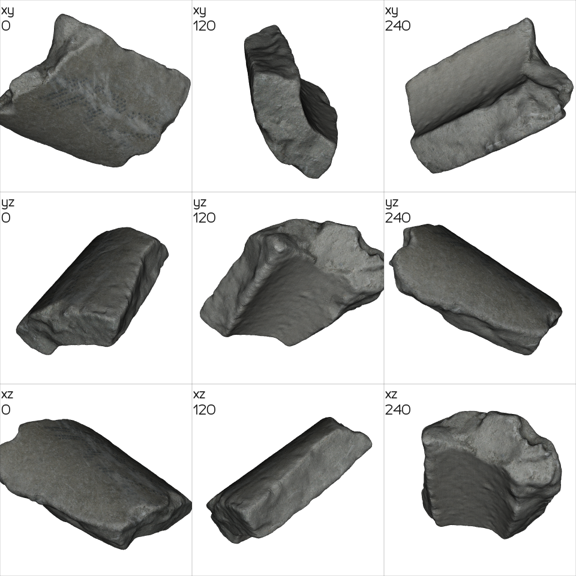

In [27]:
importlib.reload(sys.modules['src.plot_mesh_vedo']) if 'src.plot_mesh_vedo' in sys.modules else None
from src.plot_mesh_vedo import plot_mesh_vedo
fig,screenshot_path = plot_mesh_vedo(project_name,evaluation_path)
img = Image.open(screenshot_path)
scale = 0.6
display(img.resize(( int(img.width * scale), int(img.height * scale))))

In [28]:
output_path

WindowsPath('c:/Users/Tobias/Documents/Masterarbeit_lokal/synthetic_pipeline/meshroom_data/Moving_MS_20_2_3cams_6')